K-Nearest Neighbours Algorithm

In [5]:
import openml
from collections import Counter
import numpy as np
from scipy.spatial.distance import euclidean,chebyshev
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.feature_selection import f_classif,mutual_info_classif
from sklearn.model_selection import KFold
import time
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [6]:
class BaseEstimator:
    y_required = True
    fit_required = True

    def _setup_input(self, X, y=None):
        """Ensure inputs to an estimator are in the expected format.

        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. Enables estimators to define whether
        they require a set of y target values or not with y_required, e.g.
        kmeans clustering requires no target labels and is fit against only X.

        Parameters
        ----------
        X : array-like
            Feature dataset.
        y : array-like
            Target values. By default is required, but if y_required = false
            then may be omitted.
        """
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Got an empty matrix.")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")

            if not isinstance(y, np.ndarray):
                y = np.array(y)

            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")

        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

    def _predict(self, X=None):
        raise NotImplementedError()


class KNNBase(BaseEstimator):
    def __init__(self, k=5, distance_func=euclidean):
        """Base class for Nearest neighbors classifier and regressor.

        Parameters
        ----------
        k : int, default 5
            The number of neighbors to take into account. If 0, all the
            training examples are used.
        distance_func : function, default euclidean distance
            A distance function taking two arguments. Any function from
            scipy.spatial.distance will do.
            It can be chebyschev:This distance metric calculates the maximum
            absolute distance between the coordinates of the points. It's named after Pafnuty 
            Chebyshev, who was a Russian mathematician known for his work in various fields of mathematics.
            Or cityblock or minkowski

        """

        self.k = None if k == 0 else k  # l[:None] returns the whole list
        self.distance_func = distance_func

    def aggregate(self, neighbors_targets):
        raise NotImplementedError()

    def _predict(self, X=None):             
        predictions = [self._predict_x(x) for x in X]

        return np.array(predictions)

    def _predict_x(self, x):
        """Predict the label of a single instance x."""

        # compute distances between x and all examples in the training set.
        distances = (self.distance_func(x, example) for example in self.X)

        # Sort all examples by their distance to x and keep their target value.
        neighbors = sorted(((dist, target) for (dist, target) in zip(distances, self.y)), key=lambda x: x[0])

        # Get targets of the k-nn and aggregate them (most common one or
        # average).
        neighbors_targets = [target for (_, target) in neighbors[: self.k]]

        return self.aggregate(neighbors_targets)    


class KNNClassifier(KNNBase):
    """Nearest neighbors classifier.

    Note: if there is a tie for the most common label among the neighbors, then
    the predicted label is arbitrary."""

    def aggregate(self, neighbors_targets):
        """Return the most common target label."""

        most_common_label = Counter(neighbors_targets).most_common(1)[0][0]
        return most_common_label

Implementation of KNN-BAB

In [7]:
class KNNBase2(BaseEstimator):
    def __init__(self, k=7):

        self.k = None if k == 0 else k 
        self.distance_func = self.weighted_euclidean

    def aggregate(self, neighbors_targets):
        raise NotImplementedError()
    
    def normalize(self, X):
        """Normalize the feature vectors."""
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        normalized_X = (X - mean) / std
        return normalized_X

    def calculate_attribute_weight(self,X,y,a,b,c):
        f_val=self.calculate_fvalues(X,y)/sum(self.calculate_fvalues(X,y))
        mi_scores=(self.calculate_mi_scores(X,y)/sum(self.calculate_mi_scores(X,y)))
        fisher_score=(self.calculate_fisherscore(X,y)/sum(self.calculate_fisherscore(X,y)))
        self.weights=a*f_val+b*mi_scores+c*fisher_score
        return sum(self.calculate_mi_scores(X,y))

    def calculate_fvalues(self, X, y):
        f_values, _ = f_classif(X, y)
        return f_values
    
    def calculate_fisherscore(self,X,y):
        fisher_scores = []
        for feature in range(X.shape[1]):
            classes = np.unique(y)
            class_scores = []
            for c in classes:
                class_data = X[y == c, feature]
                class_scores.append(np.var(class_data))
            between_class_variance = np.mean(class_scores)
            within_class_variance = np.var(X[:, feature])
            fisher_scores.append(between_class_variance / (within_class_variance + 1e-6))
        return fisher_scores
    
    def calculate_mi_scores(self,X,y):
        return mutual_info_classif(X,y)

    def fit(self, X, y,a=0.1,b=0.8,c=0.1):
        X=self.normalize(X)
        super().fit(X, y)
        sum=self.calculate_attribute_weight(X,y,a,b,c)   
        return sum   

    def weighted_euclidean(self, x, y):
        squared_diff = [(xi - yi) ** 2 for xi, yi in zip(x, y)]
        weighted_squared_diff = [wi * sd for wi, sd in zip(self.weights, squared_diff)]
        distance = np.sqrt(sum(weighted_squared_diff))
        return distance

    def _predict(self, X=None):
        X=self.normalize(X)
        predictions = [self._predict_x(x) for x in X]

        return np.array(predictions)

    def _predict_x(self, x):
        """Predict the label of a single instance x."""
        distances = np.array([self.weighted_euclidean(x, example) for example in self.X])
        neighbors = sorted(zip(distances, self.y), key=lambda x: x[0])
        neighbors_targets = [target for (_, target) in neighbors[:self.k]]
        return self.aggregate(neighbors_targets)
        


class KNNClassifier2(KNNBase2):
    """Nearest neighbors classifier.

    Note: if there is a tie for the most common label among the neighbors, then
    the predicted label is arbitrary."""

    def aggregate(self, neighbors_targets):
        """Return the most common target label."""

        most_common_label = Counter(neighbors_targets).most_common(1)[0][0]
        return most_common_label

KNN-Implementations Perfomance on a Chosen Dataset

In [19]:
def run_benchmark_dataset(dataset_num,models, model_names):
    results = pd.DataFrame(columns=["model", "score"]) # create dataframe for results
    dataset = openml.datasets.get_dataset(dataset_num)
    # Fetch dataset features and labels
    X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
    X = X.values  # Convert X to a NumPy array
    y = y.values  # Convert y to a NumPy array

    # Define number of folds for cross-validation
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for model in range(len(models)):
        accuracies = []
        # Iterate over each fold
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # Instantiate KNN Classifier
            knn_classifier = models[model]  # Adjust k as needed
            
            # Train the model
            knn_classifier.fit(X_train, y_train)
            
            # Make predictions
            y_pred = knn_classifier.predict(X_test)
            
            # Calculate accuracy for this fold
            accuracy = accuracy_score(y_test, y_pred)
            
            # Append accuracy to the list
            accuracies.append(accuracy)

        # Calculate average accuracy across all folds
        score = np.mean(accuracies)
        
        if model_names:
            results = pd.concat([results, pd.DataFrame([[model_names[model], score]], columns=results.columns)], ignore_index=True) # insert the metric for a models and a dataset
        else:
            results = pd.concat([results, pd.DataFrame([[str(models[model]), score]], columns=results.columns)], ignore_index=True) # insert the metric for a models and a dataset
    results.to_csv("results.csv", index=False)
    return score

KNN = KNNClassifier()
KNN2 = KNNClassifier2()
models = [KNN, KNN2]
model_names = ["OriginalKNN","KNN-BAB"]
run_benchmark_dataset("diabetes",models=models, model_names=model_names)
results = pd.read_csv("results.csv")
results

,model,score
0,OriginalKNN,0.687539
1,KNN-BAB,0.738341


Mean Accuracy of KNN-BAB for Different k Values

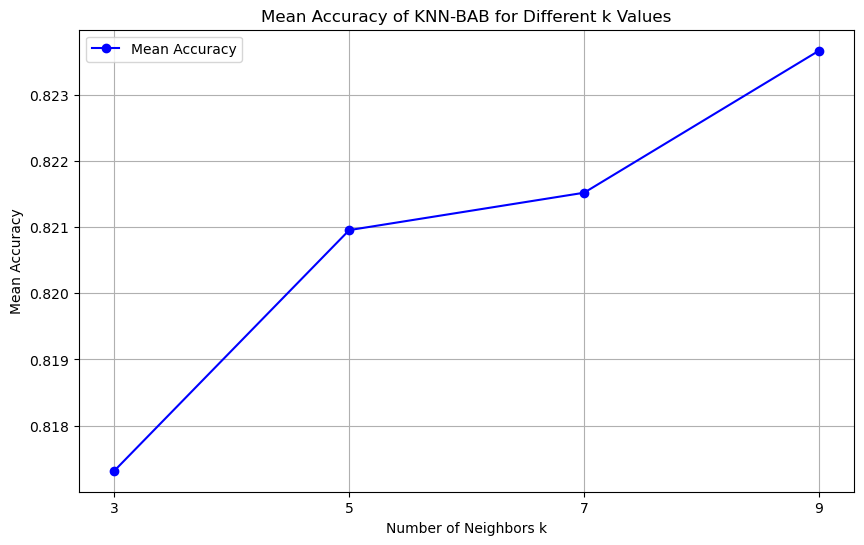

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Dados de acurácia para diferentes valores de k
k_values = [3, 5, 7, 9]
results = {
    18: [0.705494, 0.724500, 0.721997, 0.717969],
    37: [0.742188, 0.742229, 0.740915, 0.744976],
    54: [0.689125, 0.697362, 0.698593, 0.710402],
    458: [0.995247, 0.995245, 0.995248, 0.995259],
    1049: [0.887517, 0.892998, 0.889578, 0.897119],
    1510: [0.961329, 0.956047, 0.957779, 0.959546],
    40982: [0.740340, 0.738293, 0.746515, 0.740365]
}

# Calcular a média de acurácia para cada k
mean_accuracies = []
for k_index in range(len(k_values)):
    k_accuracies = [results[dataset_id][k_index] for dataset_id in results]
    mean_accuracies.append(np.mean(k_accuracies))

# Plotar a média das precisões
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_accuracies, marker='o', linestyle='-', color='b', label='Mean Accuracy')

plt.title('Mean Accuracy of KNN-BAB for Different k Values')
plt.xlabel('Number of Neighbors k')
plt.ylabel('Mean Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()


Comparison of Mean Accuracy and Mean Time Consumed for Different k Values

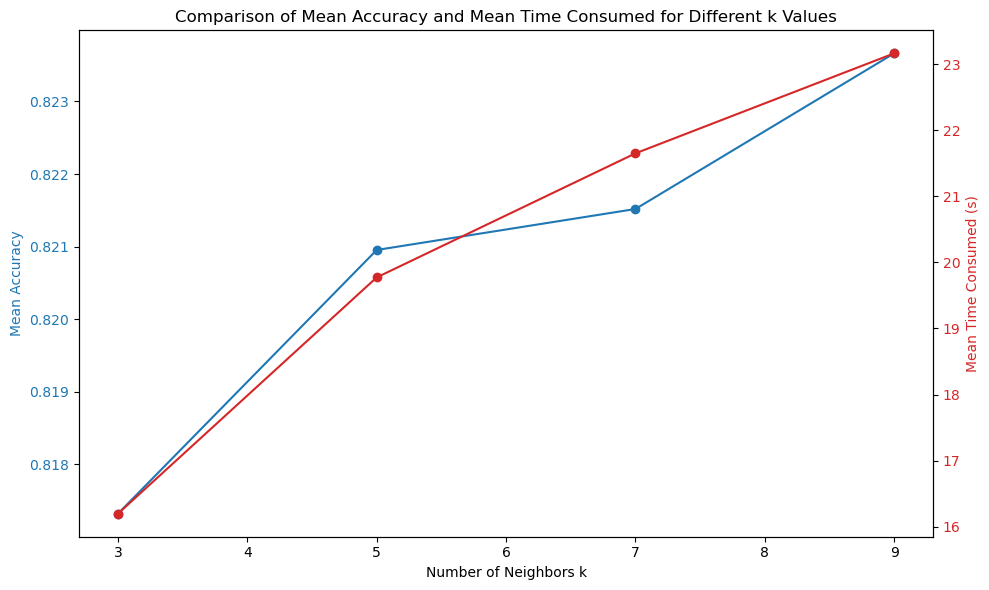

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Dados de acurácia para diferentes valores de k
k_values = [3, 5, 7, 9]
results = {
    18: [0.705494, 0.724500, 0.721997, 0.717969],
    37: [0.742188, 0.742229, 0.740915, 0.744976],
    54: [0.689125, 0.697362, 0.698593, 0.710402],
    458: [0.995247, 0.995245, 0.995248, 0.995259],
    1049: [0.887517, 0.892998, 0.889578, 0.897119],
    1510: [0.961329, 0.956047, 0.957779, 0.959546],
    40982: [0.740340, 0.738293, 0.746515, 0.740365]
}

# Dados de tempo para diferentes valores de k
time_results = {
    3: [16.505997, 2.829000, 5.716000, 17.255180, 28.787792, 3.911165, 38.356625],
    5: [20.161500, 3.444663, 7.099365, 21.587721, 33.910668, 4.936051, 47.275668],
    7: [21.893774, 3.839257, 7.988759, 24.214216, 36.724448, 5.558869, 51.349694],
    9: [22.994765, 4.101032, 8.550422, 27.540103, 39.027081, 6.045969, 53.913033]
}

# Calcular a média de acurácia e tempo para cada k
mean_accuracies = []
mean_times = []

for k_index in range(len(k_values)):
    k = k_values[k_index]
    k_accuracies = [results[dataset_id][k_index] for dataset_id in results]
    mean_accuracies.append(np.mean(k_accuracies))
    mean_times.append(np.mean(time_results[k]))

# Criar a figura e os eixos
fig, ax1 = plt.subplots(figsize=(10, 6))

# Eixo para a acurácia
color = 'tab:blue'
ax1.set_xlabel('Number of Neighbors k')
ax1.set_ylabel('Mean Accuracy', color=color)
ax1.plot(k_values, mean_accuracies, marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Criar um segundo eixo Y para os tempos usando o mesmo eixo X
ax2 = ax1.twinx()  # Cria um segundo eixo que compartilha o mesmo eixo X
color = 'tab:red'
ax2.set_ylabel('Mean Time Consumed (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(k_values, mean_times, marker='o', linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Comparison of Mean Accuracy and Mean Time Consumed for Different k Values')
fig.tight_layout()  # Para garantir que o layout não sobreponha nada
plt.show()


Comparison of Mean Accuracy for Different Distance Functions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


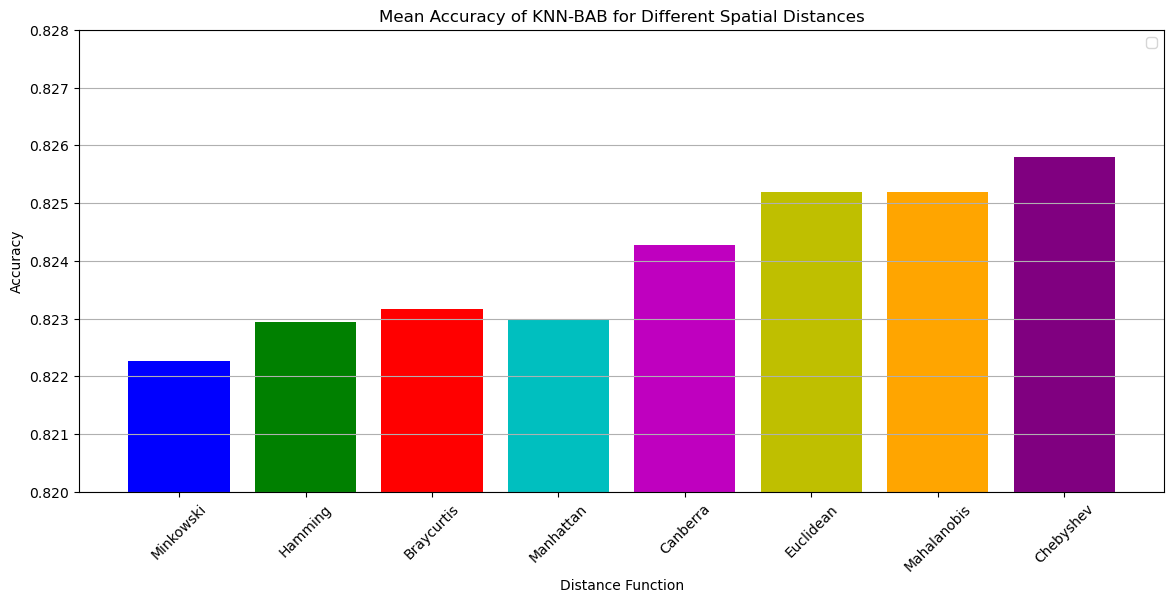

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Dados de acurácia para diferentes distance functions
dists = ['Minkowski', 'Hamming', 'Braycurtis', 'Manhattan', 'Canberra', 'Euclidean', 'Mahalanobis', 'Chebyshev']
results = {
    18: [0.717969, 0.717969, 0.717969, 0.717969, 0.717969, 0.717969, 0.717969, 0.717969],
    37: [0.742286, 0.739672, 0.744900, 0.750068, 0.751467, 0.746238, 0.752759, 0.750099],
    54: [0.704492, 0.712766, 0.708038, 0.705674, 0.708038, 0.716312, 0.717494, 0.721040],
    458: [0.995259, 0.995259, 0.995259, 0.995259, 0.995259, 0.995259, 0.996441, 0.995259],
    1049: [0.894376, 0.895062, 0.895062, 0.892318, 0.895748, 0.899863, 0.892318, 0.895748],
    1510: [0.959546, 0.959546, 0.959546, 0.957782, 0.959546, 0.957782, 0.959546, 0.959546],
    40982: [0.741913, 0.740367, 0.741396, 0.741915, 0.741911, 0.742944, 0.739853, 0.740882]
}

# Calcular a média de acurácia para cada function
mean_accuracies = []
for d_index in range(len(dists)):
    dist_accuracies = [results[dataset_id][d_index] for dataset_id in results]
    mean_accuracies.append(np.mean(dist_accuracies))

# Cores para as barras
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'purple']

# Plotar a média das precisões como gráfico de barras
plt.figure(figsize=(14, 6))
plt.bar(dists, mean_accuracies, color=colors, label='')

plt.title('Mean Accuracy of KNN-BAB for Different Spatial Distances')
plt.xlabel('Distance Function')
plt.ylabel('Accuracy')
plt.ylim(0.82, 0.828)  # Ajustar a escala do eixo y para aumentar a visibilidade das diferenças
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y')

plt.show()


Finding solution (a,b,c) that optimizes Accuracy

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
def run_benchmark_accuracy(dataset_num,a,b,c,models, model_names):
    results = pd.DataFrame(columns=["model", "score"]) # create dataframe for results
    dataset = openml.datasets.get_dataset(dataset_num)
    # Fetch dataset features and labels
    X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
    X = X.values  # Convert X to a NumPy array
    y = y.values  # Convert y to a NumPy array

    # Define number of folds for cross-validation
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for model in range(len(models)):
        accuracies = []
        # Iterate over each fold
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # Instantiate KNN Classifier
            knn_classifier = models[model]  # Adjust k as needed
            
            # Train the model
            knn_classifier.fit(X_train, y_train,a,b,c)
            
            # Make predictions
            y_pred = knn_classifier.predict(X_test)
            
            # Calculate accuracy for this fold
            accuracy = accuracy_score(y_test, y_pred)
            
            # Append accuracy to the list
            accuracies.append(accuracy)

        # Calculate average accuracy across all folds
        score = np.mean(accuracies)
        
        
        results = pd.concat([results, pd.DataFrame([[model_names[model], score]], columns=results.columns)], ignore_index=True) # insert the metric for a models and a dataset
        
    results.to_csv("results.csv", index=False)
    return score

# Define the range of values for a, b, and c
a_values = np.arange(0, 1.1, 0.1)
b_values = np.arange(0, 1.1, 0.1)
c_values=np.arange(0,1.1,0.1)

best_accuracy = 0
best_weights = None
KNN2 = KNNClassifier2()
models = [KNN2]
model_names = ["KNN-BAB"]

# Iterate over all combinations of a, b, and c
for a in a_values:
    for b in b_values:
        for c in c_values:
            if a+b+c==1:
                weights = (a, b, c)
                accuracies = []
                # Assuming datasets is a list of your datasets
                for dataset in [37,54,1510]:
                    accuracy=run_benchmark_accuracy(dataset,a,b,c,models=models, model_names=model_names)
                    accuracies.append(accuracy)
                avg_accuracy = np.mean(accuracies)
                if avg_accuracy > best_accuracy:
                    best_accuracy = avg_accuracy
                    best_weights = weights

print("Best weights:", best_weights)
print("Best average accuracy:", best_accuracy)


Best weights: (0.1, 0.8, 0.1)
Best average accuracy: 0.8031838415142912


Predicting KNN-Implementations Perfomance

In [16]:
def run_benchmark(models, model_names):
    results = pd.DataFrame(columns=["Dataset", "Original KNN","KNN-BAB"]) # create dataframe for results
    selected_benchmark_datasets=[11, 18, 37, 54, 458, 1049, 1501, 1510, 40979, 40982]
    for id in selected_benchmark_datasets:
        dataset = openml.datasets.get_dataset(id)
        # Fetch dataset features and labels
        X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
        X = X.values  # Convert X to a NumPy array
        y = y.values  # Convert y to a NumPy array
        scores=[]
        # Define number of folds for cross-validation
        k = 10
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        for model in range(len(models)):
            accuracies = []

            # Iterate over each fold
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                # Instantiate KNN Classifier
                knn_classifier = models[model]  # Adjust k as needed
                
                # Train the model
                sum_mutual_info=knn_classifier.fit(X_train, y_train)
                
                # Make predictions
                y_pred = knn_classifier.predict(X_test)
                
                # Calculate accuracy for this fold
                accuracy = accuracy_score(y_test, y_pred)
                
                # Append accuracy to the list
                accuracies.append(accuracy)

            # Calculate average accuracy across all folds
            score = np.mean(accuracies)
            scores.append(score)
        results = pd.concat([results, pd.DataFrame([[id, scores[0],scores[1]]], columns=results.columns)], ignore_index=True)
    results.to_csv("results.csv", index=False)

In [18]:
KNN = KNNClassifier()
KNN2 = KNNClassifier2()
models = [KNN,KNN2]
model_names = ["Original KNN","KNN-BAB"]
run_benchmark(models=models, model_names=model_names)
results = pd.read_csv("results.csv")
results

,Dataset,Original KNN,KNN-BAB
0,11,0.835305,0.872069
1,18,0.459000,0.714500
2,37,0.699214,0.753947
3,54,0.656106,0.709174
4,458,0.468543,0.992871
5,1049,0.863500,0.896453
6,1501,0.730668,0.917150
7,1510,0.936654,0.952600
8,40979,0.823000,0.977000
9,40982,0.461634,0.742424


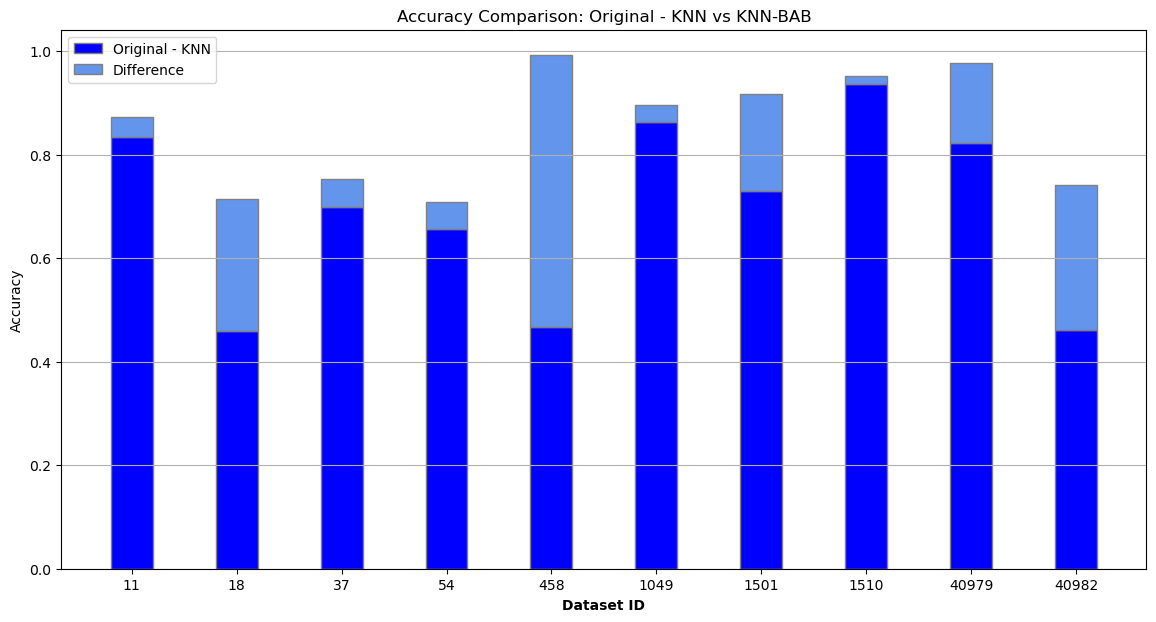

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data
data = {
    'Dataset ID': [11.0, 18.0, 37.0, 54.0, 458.0, 1049.0, 1501.0, 1510.0, 40979.0, 40982.0],
    'Original - KNN': [0.835, 0.459, 0.699, 0.656, 0.468, 0.863, 0.730, 0.937, 0.823, 0.462],
    'KNN-BAB': [0.872, 0.714, 0.753, 0.709, 0.992, 0.896, 0.917, 0.952, 0.977, 0.742]
}

# Create DataFrame
df = pd.DataFrame(data)
df['Dataset ID'] = df['Dataset ID'].astype(int)

# Set up the figure
plt.figure(figsize=(14, 7))

# Define bar width
bar_width = 0.4

# Set positions for bars on the x-axis
r1 = np.arange(len(df))

# Create bars for Original - KNN with same base color
plt.bar(r1, df['Original - KNN'], color='blue', width=bar_width, edgecolor='grey', label='Original - KNN')

# Create bars for the difference (KNN-BAB - Original KNN) with a different color
plt.bar(r1, df['KNN-BAB'] - df['Original - KNN'], bottom=df['Original - KNN'], color='cornflowerblue', width=bar_width, edgecolor='grey', label='Difference')

# Add xticks on the middle of the group bars
plt.xlabel('Dataset ID', fontweight='bold')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: Original - KNN vs KNN-BAB')
plt.xticks(r1, df['Dataset ID'])

# Create legend
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()


Correlation coefficient: 0.8445957273947361


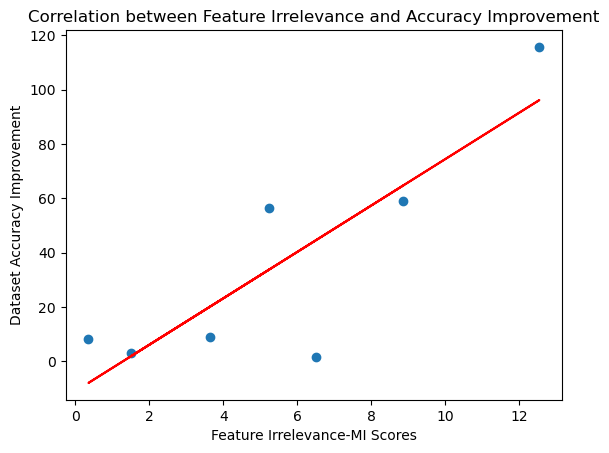

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Insert your own data
x = [5.225235,0.352197,3.631910,12.537757,1.502593,6.513620,8.854535]  # example x-values
y = [56.263,8.33,8.91,115.735,3.16,1.69,58.9]
# Calculate the line of best fit
coefficients = np.polyfit(x, y, 1)
line = np.poly1d(coefficients)
plt.plot(x, line(x), color='red', label='Line of Best Fit')

# Plot the points
plt.scatter(x, y)
plt.title("Correlation between Feature Irrelevance and Accuracy Improvement")
plt.xlabel("Feature Irrelevance-MI Scores")
plt.ylabel("Dataset Accuracy Improvement")

# Calculate the correlation coefficient
correlation = np.corrcoef(x, y)[0, 1]
print("Correlation coefficient:", correlation)

plt.show()
